## Outlier Engineering


An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, **some Machine Learning models are sensitive to outliers** which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables.

We discussed in section 3 of this course how to identify outliers. In this section, we we discuss how we can process them to train our machine learning models.


## How can we pre-process outliers?

- Trimming: remove the outliers from our dataset
- Treat outliers as missing data, and proceed with any missing data imputation technique
- Discrestisation: outliers are placed in border bins together with higher or lower values of the distribution
- Censoring: capping the variable distribution at a max and / or minimum value

**Censoring** is also known as:

- top and bottom coding
- windsorisation
- capping


## Censoring or Capping.

**Censoring**, or **capping**, means capping the maximum and /or minimum of a distribution at an arbitrary value. On other words, values bigger or smaller than the arbitrarily determined ones are **censored**.

Capping can be done at both tails, or just one of the tails, depending on the variable and the user.

Check my talk in [pydata](https://www.youtube.com/watch?v=KHGGlozsRtA) for an example of capping used in a finance company.

The numbers at which to cap the distribution can be determined:

- arbitrarily
- using the inter-quantal range proximity rule
- using the gaussian approximation
- using quantiles


### Advantages

- does not remove data

### Limitations

- distorts the distributions of the variables
- distorts the relationships among variables


## In this Demo

We will see how to perform capping with the gaussian approximation using the Boston House Dataset

## Important

When doing capping, we tend to cap values both in train and test set. It is important to remember that the capping values MUST be derived from the train set. And then use those same values to cap the variables in the test set

I will not do that in this demo, but please keep that in mind when setting up your pipelines

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

from feature_engine.outlier_removers import Winsorizer

In [2]:
# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()

# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# add the target
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [3]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

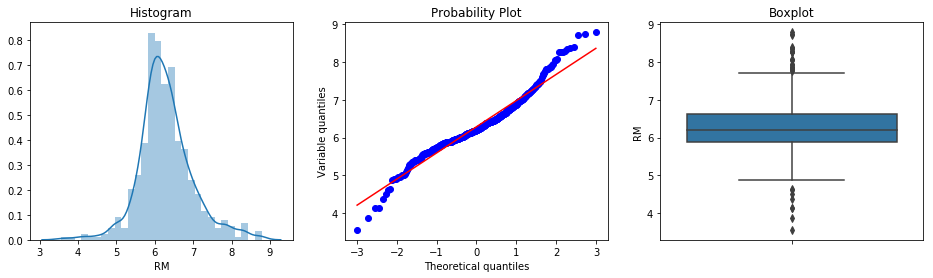

In [4]:
# let's find outliers in RM

diagnostic_plots(boston, 'RM')

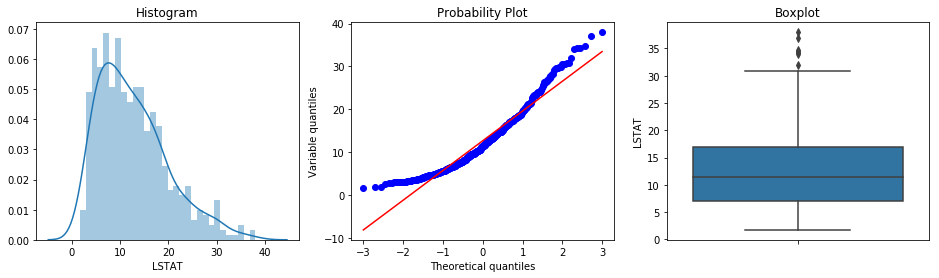

In [5]:
# visualise outliers in LSTAT

diagnostic_plots(boston, 'LSTAT')

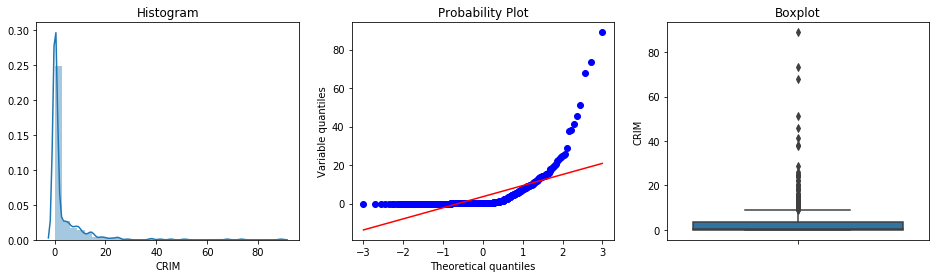

In [6]:
# outliers in CRIM

diagnostic_plots(boston, 'CRIM')

There are outliers in all of the above variables. RM shows outliers in both tails, whereas LSTAT and CRIM only on the right tail.

To find the outliers, let's re-utilise the function we learned in section 3:

In [7]:
def find_normal_boundaries(df, variable, distance):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return upper_boundary, lower_boundary

In [8]:
# find limits for RM

RM_upper_limit, RM_lower_limit = find_normal_boundaries(boston, 'RM', 3)
RM_upper_limit, RM_lower_limit

(8.392485817597757, 4.176782957105816)

In [9]:
# limits for LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_normal_boundaries(boston, 'LSTAT', 3)
LSTAT_upper_limit, LSTAT_lower_limit

(34.07624777515244, -8.77012129293899)

In [10]:
# limits for CRIM

CRIM_upper_limit, CRIM_lower_limit = find_normal_boundaries(boston, 'CRIM', 3)
CRIM_upper_limit, CRIM_lower_limit

(29.418158873309714, -22.19111175868521)

In [11]:
# Now let's replace the outliers by the maximum and minimum limit

boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [12]:
# Now let's replace the outliers by the maximum and minimum limit

boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [13]:
# Now let's replace the outliers by the maximum and minimum limit

boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

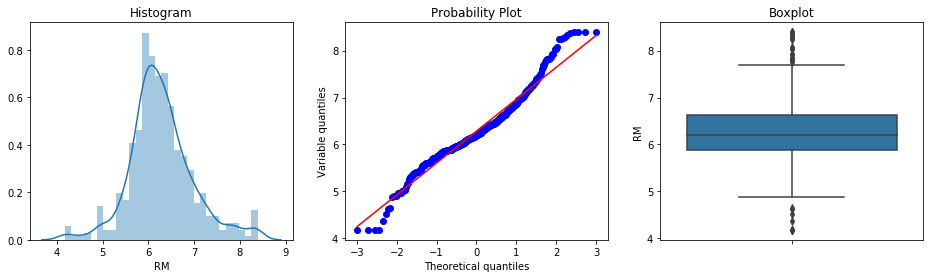

In [14]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

diagnostic_plots(boston, 'RM')

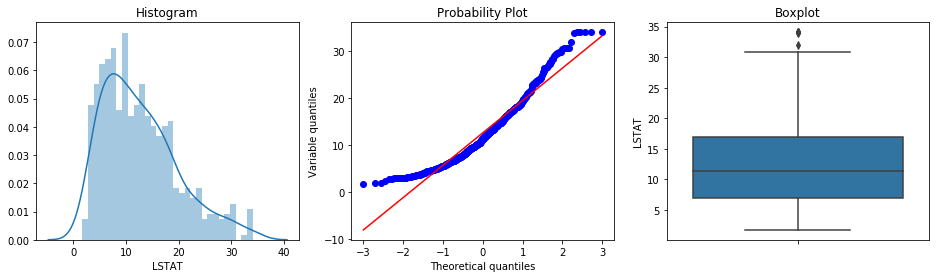

In [15]:
diagnostic_plots(boston, 'LSTAT')

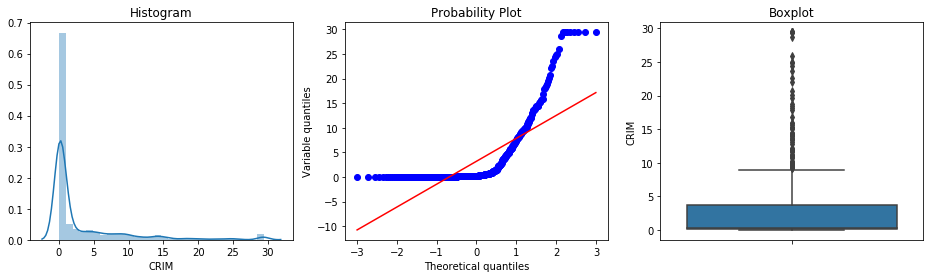

In [16]:
diagnostic_plots(boston, 'CRIM')

None of these variables are normally distributed, that is probably why the Gaussian approximation was not so effective to remove outliers. We could try and use a smaller distance, instead of multiplying by 3 times the std, we could 2 times or 1.5. But those numbers are set arbitrarily, and do not pose much statistical sense, therefore defeating the point of using the Gaussian approximation.

If this capping does not work as desired, I recommend you use the IQR rule as we discussed in the previous notebook, or quantiles, as we will see in the next one.

## Censoring with feature-engine

In [17]:
# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()

# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# add the target
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [18]:
# create the capper

windsoriser = Winsorizer(distribution='gaussian', # choose iqr for skewed or gaussian
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)

Winsorizer(distribution='gaussian', fold=3, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [19]:
boston_t = windsoriser.transform(boston)

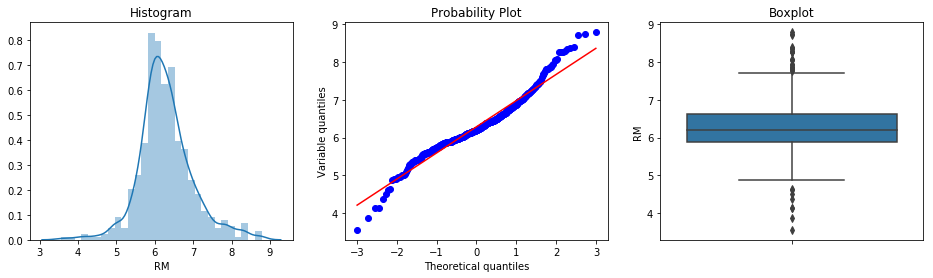

In [20]:
diagnostic_plots(boston, 'RM')

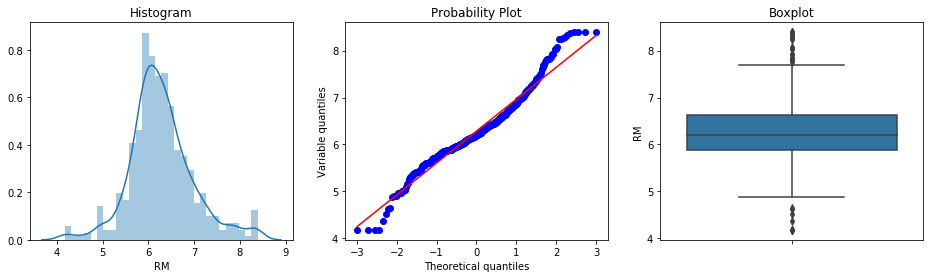

In [21]:
diagnostic_plots(boston_t, 'RM')

In [22]:
# we can inspect the minimum caps for each variable
windsoriser.left_tail_caps_

{'RM': 4.176782957105816,
 'LSTAT': -8.77012129293899,
 'CRIM': -22.19111175868521}

In [23]:
# we can inspect the maximum caps for each variable
windsoriser.right_tail_caps_

{'RM': 8.392485817597757,
 'LSTAT': 34.07624777515244,
 'CRIM': 29.418158873309714}

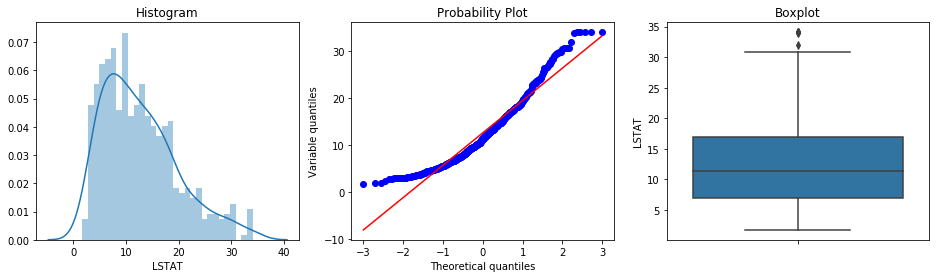

In [24]:
diagnostic_plots(boston_t, 'LSTAT')

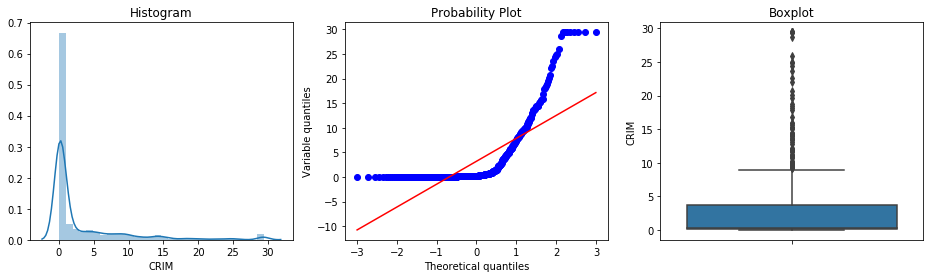

In [25]:
diagnostic_plots(boston_t, 'CRIM')

None of these variables are normally distributed, that is probably why the Gaussian approximation was not so effective to remove outliers. We could try and use a smaller distance, instead of multiplying by 3 times the std, we could 2 times or 1.5. But those numbers are set arbitrarily, and do not pose much statistical sense, therefore defeating the point of using the Gaussian approximation.

If this capping does not work as desired, I recommend you use the IQR rule as we discussed in the previous notebook, or quantiles, as we will see in the next one.